Import the header files

In [5]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit import Model, fit_report
import nmrglue as ng
import pandas as pd
from pathlib import Path, PureWindowsPath
import os
import scipy.io as sio
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
script_dir = os.getcwd()
sns.set_theme(style="ticks", palette=None)

plt.rcParams['text.usetex'] = True
# plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Charter"],
})
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



data_nucleus = os.path.join(script_dir + '\\support_files\\IsotopeProperties.csv')
df=pd.read_csv(data_nucleus)

### Pseudo Voigt function for NMR
Create a pseudo Voigt function.  
Voigt function is a convolution of Gaussian and Cauchy distribution.  
Pseudo Voigt function is a summation of both. It is an approximation.  
After derivation, pseudo Voigt function for NMR is written in the function below.

In [6]:
log2=np.log(2)

def pvoigt_nmr(x, peakheight, peakposn, linewidth, fraction):
    """Return a 1D NMR lineshape function """
    sigma=linewidth/2.0
    sigmag=sigma/np.sqrt(2*log2)
    amplitude = (((peakheight)/2) * np.pi * linewidth)/(1+fraction*(np.sqrt(np.pi*log2)-1)) 
    g_nmr = (((1-fraction)*amplitude)/(sigmag*np.sqrt(2*np.pi)))*np.exp(-((x-peakposn)**2/(2*sigmag**2)))
    l_nmr = (1/np.pi)*fraction*amplitude*sigma**1/((x-peakposn)**2+sigma**2)
    return g_nmr + l_nmr

In [7]:

def fit_with_sidebands(data, xppm,
                        spin_freq ,
                        num_cen,
                        num_ssb,
                        posn,
                        posn_var,
                        fwhh,
                        fwhh_var,
                        peak_heights,
                        larm_freq):
    numpeaks = (2 * num_ssb) * num_cen + num_cen
    mod = Model(pvoigt_nmr,prefix='p1_')
    for i in range(1, numpeaks):
        mod = mod + Model(pvoigt_nmr, prefix='p%d_'%(i+1))
        
    pars = mod.make_params()

    for i in range(0, num_cen):
        pars[f'p{num_ssb*num_cen+1+i}_peakposn'].set(value=posn[i], min=posn_var[i][0], max=posn_var[i][1])
        pars[f'p{num_ssb*num_cen+1+i}_linewidth'].set(value=fwhh[i], min = fwhh_var[i][0], max = fwhh_var[i][1])
        pars[f'p{num_ssb*num_cen+1+i}_fraction'].set(value=0.8, min = 0., max = 1.0)
    
    ss_num = np.arange(num_ssb, -(num_ssb+1), -1)
    
    
    for i in range(1, num_cen+1):
        k = np.arange(i, numpeaks+1, num_cen)
        for j in range(len(ss_num)):
            if (k[j] != k[j]+ss_num[j]*num_cen):
                posn_ss =  posn[i-1]+(-ss_num[j]*spin_freq/larm_freq)
                pars[f'p{k[j]}_peakposn'].set(value = posn_ss[0], min = posn_ss[0]-2, max=posn_ss[0]+2)
                pars[f'p{k[j]}_linewidth'].set(expr = f'p{k[j]+ss_num[j]*num_cen}_linewidth')
                pars[f'p{k[j]}_fraction'].set(expr = f'p{k[j]+ss_num[j]*num_cen}_fraction')
            
    
    for i in range(1, numpeaks+1):
        pars[f'p{i}_peakheight'].set(value=peak_heights[i-1], min=1e-12, max=1.0)
    
    init = mod.eval(pars, x=xppm)
    out = mod.fit(data, pars, x=xppm, method='least_squares')
    comps = out.eval_components(x=xppm)
    dely = out.eval_uncertainty(sigma=3)
    return init, out, comps, dely

In [22]:

data_folder = PureWindowsPath('nmr_directory')
dic, data = ng.bruker.read_pdata(str(data_folder)+'\\proc_num\\pdata\\1')
udic = ng.bruker.guess_udic(dic, data)
uc = ng.fileiobase.uc_from_udic(udic)
xppm_all = uc.ppm_scale()
xppm = xppm_all[(xppm_all > -150) & (xppm_all < 50)]
f = data[(xppm_all > -150) & (xppm_all < 50)]
data=f.astype('float64')
data_norm=data/max(data)

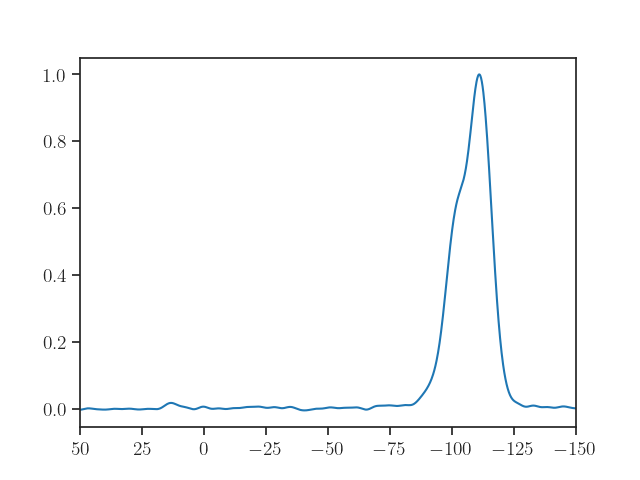

In [23]:
plt.close('all')
plt.plot(xppm,data_norm)
plt.xlim([50,-150])
plt.show()

In [24]:
nuc = '29Si'
nuc_choice=df.loc[df['Mass'] + df['Nucleus'] == nuc]
larmor_freq=nuc_choice["Gamma (MHz/T)"].to_numpy().astype(float)
gyr=larmor_freq.astype(float)
mag_field = 9.4
spin_freq = 6500
num_cen = 3
num_ssb = 0
posn = np.array([-110, -100, 13])
posn_var = np.array([[-111, -109], [-101, -99], [12, 15]])
fwhh = np.array([5, 5, 5])
fwhh_var = np.array([[0, 20], [0, 20], [0, 20]])
peak_heights = np.array([0.75, 1.00, 0.05])
larm_freq = gyr * mag_field

init_arg, out_arg, comps_arg, dely_arg = fit_with_sidebands(data_norm, xppm, spin_freq, num_cen,
                                                            num_ssb,
                                                            posn,
                                                            posn_var,
                                                            fwhh,
                                                            fwhh_var,
                                                            peak_heights,
                                                            larm_freq)

Param     fraction  linewidth  peakheight  peakposn      integral  percentage
Peak Num                                                                     
p1          0.0000    11.2775      0.6400 -111.0000  8.610675e+08   64.497096
p2          0.6744     9.3342      0.5532 -100.6233  4.664128e+08   34.936020
p3          0.0000     5.7151      0.0111   12.8292  7.568176e+06    0.566884


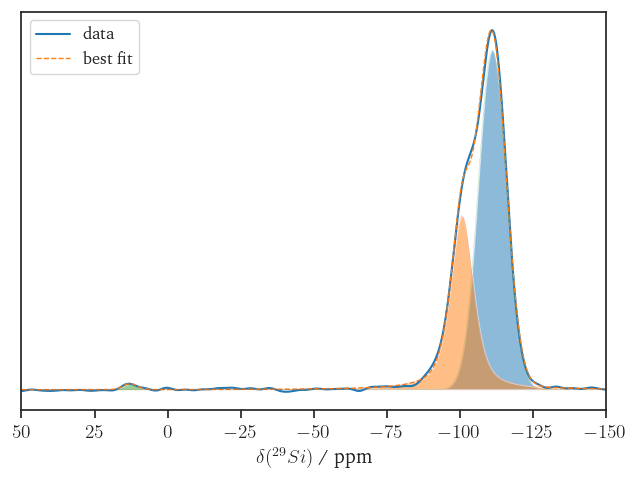

In [25]:
# print('-------------------------------')
# print('Parameter    Value       Stderr')

my_list=[]
for name, param in out_arg.params.items():
    peakattrib=name.split('_')
    my_list.append([peakattrib[0], peakattrib[1], np.round(param.value,4), np.round(param.stderr,4)])

column_names=['Peak Num', 'Param', 'Values', 'Error']
fitted_values=pd.DataFrame(my_list, columns=column_names)
fv=fitted_values.pivot(index='Peak Num', columns='Param', values='Values')
fv['integral'] = (((fv['peakheight'])/2) * np.pi * fv['linewidth'])/(1+fv['fraction']*(np.sqrt(np.pi*log2)-1)) *max(data)
fv['percentage'] = 100*fv['integral']/fv['integral'].sum()
print(fv)
# # print('p1_peakheight'.value)


plt.close('all')
fig, ax = plt.subplots()
ax.plot(xppm, data_norm, label='data')
ax.plot(xppm, out_arg.best_fit, '--', label = 'best fit', linewidth = 1)
for i in range ((2 * num_ssb) * num_cen + num_cen):
    ax.plot(xppm, comps_arg[f"p{i+1}_"], '-', linewidth = 0.1)
    ax.fill_between(xppm, 0, comps_arg[f"p{i+1}_"], alpha=0.5)
ax.set_xlim([50,-150])
ax.set_xlabel(r"$\delta (^{29}Si)$ / ppm")
ax.set_yticks([])
ax.legend()

# axins = inset_axes(ax, width="30%", height="20%", loc='center left')
# axins.plot(xppm, data_norm, label='data')
# axins.plot(xppm, out_arg.best_fit, '--', label = 'best fit', linewidth = 1)

# axins.plot(xppm, comps_arg["p5_"], '-', linewidth = 0.1)
# axins.fill_between(xppm, 0, comps_arg["p5_"], alpha=0.8)
# axins.plot(xppm, comps_arg["p4_"], '-', linewidth = 0.1)
# axins.fill_between(xppm, 0, comps_arg["p4_"], alpha=0.2)
# axins.set_xlim([30, -10])
# axins.set_ylim([-0.00, 0.003])
# axins.set_yticks([])

plt.tight_layout()
# fig.savefig(str(data_folder) + '\\INAD_with_decon.png',format='png')
# fv.to_csv(str(data_folder) + '\\INAD_decomp.csv')

Print the parameters that resulted from the fit.